In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../snakecnv/lib/'))

In [2]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from matplotlib_venn import venn2

from pysam import VariantFile

%matplotlib inline
import matplotlib

#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
%%bash
resultdir=/home/tfaraut/mnt/biomathhome/projets/CNVpipeline/tests/testdetection/detection/annotated
for f in `ls $resultdir/*/*.vcf.gz`; 
do
   echo $f
done > tmp_vcf_files.txt
bcftools concat -f tmp_vcf_files.txt | bcftools sort -Oz -o tmp_final.vcf.gz
#tabix -p vcf tmp_final.vcf.gz

Writing to /tmp/bcftools-sort.FjiSa8
Merging 1 temporary files
Cleaning
Done


In [21]:
HOM_REF = (0, 0)
HET_VAR = (0, 1)
HOM_VAR = (1, 1)

def is_variant(rec):
    variant = True
    for s in rec.samples:
        variant = variant and (rec.samples[s]['GT'] != HOM_REF and rec.samples[s]['GT'] != (None, None))
    return variant 

def quality_at_least(rec, qual=0):
    if qual == 0:
        return True
    if rec.qual is None:
        return True
    if rec.qual > qual:
        return True
    return False

def re_at_least(rec, re_cutoff=0):
    if "RE" not in rec.info:
        return True
    if rec.info["RE"] > re_cutoff:
        return True
    return False
    
def read_depth_at_most(rec, rd_cutoff=-1):
    if rd_cutoff == -1 :
        return True
    maxrd = 0 
    for s in rec.samples:
        if "RD" in rec.samples[s]:
            maxrd = max(maxrd, rec.samples[s]['DP'])
    if maxrd <= rd_cutoff:
        return True
    return False

def on_chrom(rec):
    if "NKL" in rec.chrom:
        return False
    else:
        return True

def read_vcf(vcffile, qual=0, rd_cutoff=-1, re_cutoff=0,
             variant=False, onlychrom=False, svtype=None, 
             filter=False):
    vcf_in = VariantFile(vcffile)
    records = []
    for rec in vcf_in:
        if (quality_at_least(rec, qual) and 
            read_depth_at_most(rec, rd_cutoff) and
            re_at_least(rec, re_cutoff) and
            (not variant or is_variant(rec)) and
            (not onlychrom or on_chrom(rec)) and
            (not filter or "PASS" in rec.filter) and
            (svtype is None or rec.info['SVTYPE']==svtype)):
            records.append(rec)
    return records


def valid_geno(geno):
    if geno == (0,0) or geno == (0,1) or geno == (1,1):
        return True
    else:
        return False

def is_variant(rec):
    variant = True
    for s in rec.samples:
        variant = variant and (rec.samples[s]['GT'] != (0,0) and rec.samples[s]['GT'] != (None, None))
    return variant 
    
def var_frequency(rec):
    alt_alleles = 0
    informative_samples = 0 
    for s in rec.samples:
        geno = rec.samples[s]['GT']
        if not valid_geno:
            continue
        informative_samples += 1
        if geno == (0,1):
            alt_alleles += 1
        elif geno == (1,1):
            alt_alleles += 1
    if informative_samples == 0:
        return None
    else:
        return float(alt_alleles)/informative_samples 

In [48]:
def draw_sv_length_plot(variants):
    """Makes two stacked bar charts
    Plotting two bar charts of number of SVs by length split by SV type
    Use a consistent colouring scheme for those in "standard_order" to
    make comparison reasonable
    First bar chart is up to 2kb with bins of 10bp
    Second bar chart is up to 20kb, with bins of 100bp
     and uses log scaling on the y-axis
    """
    dict_of_lengths=defaultdict(list)
    #standard_svtype = ['DEL', 'INS', 'INV', 'DUP']
    standard_svtype = ['DEL', 'INV', 'DUP']
    for v in variants:
        svtype = v.info['SVTYPE']
        if svtype in standard_svtype:
            dict_of_lengths[svtype].append(v.rlen)
    #standard_order = ['DEL', 'INS', 'INV', 'DUP_INT', 'DUP_TAN']
    fig = plt.figure(figsize=(10, 6)) 
    fig.suptitle("Distribution of variant size", fontsize=14)
    standard_order =standard_svtype
    names, lengths = zip(
            *sorted([(svtype, lengths) for svtype, lengths in dict_of_lengths.items()],
                    key=lambda x: standard_order.index(x[0])))
    plt.subplot(2, 1, 1)
    plt.hist(x=lengths,
             bins=[i for i in range(0, 2000, 10)],
             stacked=True,
             histtype='bar',
             label=names)
    plt.xlabel('Length of structural variant')
    plt.ylabel('Number of variants')
    plt.legend(frameon=False,
               fontsize="small")

    plt.subplot(2, 1, 2)
    plt.hist(x=lengths,
             bins=[i for i in range(0, 20000, 100)],
             stacked=True,
             histtype='bar',
             label=names,
             log=True)
    plt.xlabel('Length of structural variant')
    plt.ylabel('Number of variants')
    plt.legend(frameon=False,
               fontsize="small")

def frequency_spectrum(variants):
    frequencies = []
    dict_of_frequencies=defaultdict(list)
    standard_svtype = ['DEL', 'INS', 'INV', 'DUP']
    for v in variants:
        svtype = v.info['SVTYPE']
        freq = var_frequency(v)
        if svtype in standard_svtype and freq is not None:
            dict_of_frequencies[svtype].append(freq)
    fig = plt.figure(figsize=(10, 6)) 
    fig.suptitle("Variant frequeny spectrum", fontsize=14)
    standard_order = ['DEL', 'INS', 'INV', 'DUP']
    names, frequencies = zip(
            *sorted([(svtype, frequencies) for svtype, frequencies in dict_of_frequencies.items()],
                    key=lambda x: standard_order.index(x[0])))
    plt.subplot(2, 1, 1)
    plt.hist(x=frequencies,
             bins=60,
             range=(0,1),
             stacked=True,
             histtype='bar',
             label=names)
    plt.xlabel('Alternative allele frequency')
    plt.ylabel('Number of variants')
    plt.legend(frameon=False,
               fontsize="small")
    
def filter_summary(variants):
    dict_of_filters = defaultdict(Counter)  
    standard_svtype = ['DEL', 'INS', 'INV', 'DUP']
    for v in variants:
        svtype = v.info['SVTYPE']
        if svtype in standard_svtype:
            for f in v.filter:        
                dict_of_filters[svtype][f] += 1
    return dict_of_filters  

def plot_filter_summary(variants):
    counter = filter_summary(variants)
    df = pd.DataFrame.from_dict(counter, orient='index')
    df.plot.bar(rot=0, title= "Filters by variant type")    

def num_supp_samples(variants):
    return [v.info["NUM_SUPP_SAMPLES"] for v in variants]

def num_supp_reads(variants):
    dict_of_supports = defaultdict(list)  
    for rec in variants:
        for s, v in rec.samples.iteritems():
            alt_supp = v.get('AO')[0]
            ref_supp = v.get('RO')
            ratio = alt_supp/(alt_supp + ref_supp) 
            if v.get('GT') == HET_VAR:
                dict_of_supports["het"].append(ratio)
            elif v.get('GT') == HOM_VAR:
                dict_of_supports["homo_var"].append(ratio)
            elif v.get('GT') == HOM_REF:
                dict_of_supports["homo_ref"].append(ratio)
    return dict_of_supports

def plot_supp_reads(variants):
    counter = num_supp_reads(variants)
    fig, ax = plt.subplots()
    
    a_heights, a_bins = np.histogram(counter['homo_ref'], range=(0,1))
    b_heights, b_bins = np.histogram(counter['het'], bins=a_bins)
    c_heights, c_bins = np.histogram(counter['homo_var'], bins=a_bins)

    width = (a_bins[1] - a_bins[0])/3

    ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
    ax.bar(b_bins[:-1 ] + width, b_heights, width=width, facecolor='seagreen')
    ax.bar(c_bins[:-1 ] + 2*width, c_heights, width=width, facecolor='darkorange')
    

In [9]:
vcffile = "tmp_final.vcf.gz"

In [10]:
variants = read_vcf(vcffile, onlychrom=True, filter=True)

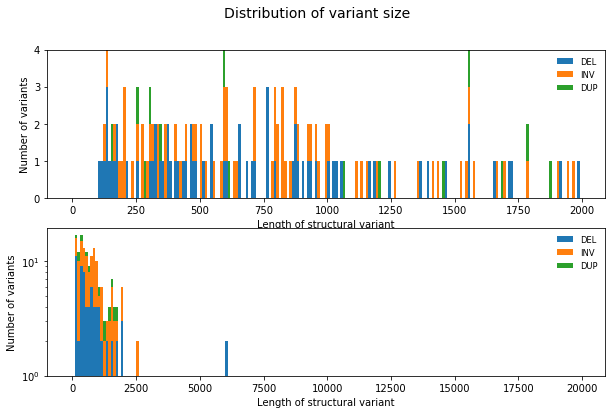

In [11]:
draw_sv_length_plot(variants)

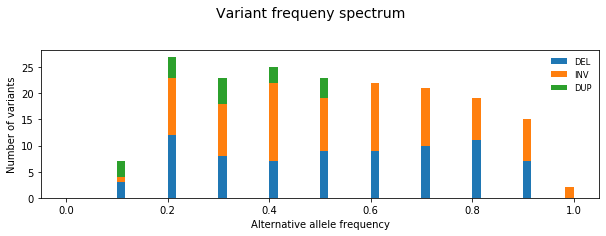

In [12]:
frequency_spectrum(variants)

In [13]:
variants = read_vcf(vcffile, onlychrom=True)

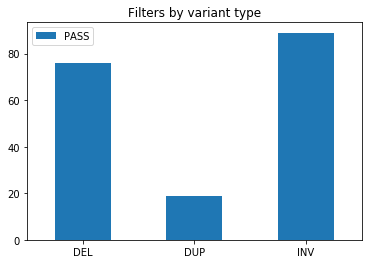

In [14]:
plot_filter_summary(variants)

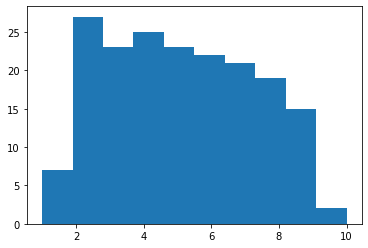

In [15]:
supp_samples = num_supp_samples(variants)
temp = plt.hist(x=supp_samples)

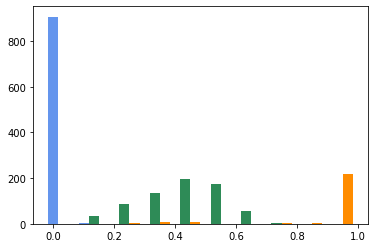

In [49]:
df = plot_supp_reads(variants)

0.5694824414026494

0.9997410510281797